In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import gamma, uniform
import seaborn as sns
import os

plt.style.use('seaborn')


# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)

In [2]:
disasters = genfromtxt('disasters.csv', delimiter = ',')

#Calculate transition probability, based on random walk proposal
def calc_probability_random_walk(tau, breakpoints_current, breakpoints_propose, labda):
    
    # Check if sorted
    if np.all(breakpoints_propose[:-1] <= breakpoints_propose[1:]):
        
        nt_current = np.histogram(tau, bins = breakpoints_current)[0].astype('int32')
        nt_propose = np.histogram(tau, bins = breakpoints_propose)[0].astype('int32')
        
        log_prob_current = (np.sum(np.log(np.diff(breakpoints_current)))
                              - np.sum(labda*np.diff(breakpoints_current)) 
                            + np.sum(nt_current*np.log(labda)))
        
        log_prob_propose = (np.sum(np.log(np.diff(breakpoints_propose)))
                            -np.sum(labda*np.diff(breakpoints_propose)) 
                            + np.sum(nt_propose*np.log(labda)))
               
        return np.minimum(1, np.exp(log_prob_propose - log_prob_current))
    
    else:
        return 0 
    
#Propose moving one single breakpoint
def proposal_random_walk(breakpoints, index, rho):
    
    ti = breakpoints[index]
    R = rho*(breakpoints[index+1] - breakpoints[index-1])
    epsilon = np.random.uniform(-R, R)
    ti_proposal = ti + epsilon
    
    new_breakpoints = breakpoints.copy()
    new_breakpoints[index] = ti_proposal
    
    return new_breakpoints

def sample_lambdas(tau, theta, breakpoints, num_breakpoints):
    
    nt_current = np.histogram(tau, bins = breakpoints)[0].astype('int32')
    diff = np.diff(breakpoints)
    
    sample_lambda = lambda i: np.random.gamma(2 + nt_current[i], 1/(theta + diff[i]))
    
    lambdas = np.apply_along_axis(sample_lambda, 0, np.arange(0, num_breakpoints + 1))
    
    return lambdas
    
def sample_theta(psi, labdas, num_breakpoints):
    
    theta = np.random.gamma(2 + 2*(num_breakpoints + 1), 1/(psi + np.sum(labdas)))
    
    return theta
    
    
def init_mcmc(N, num_breakpoints, psi, rho, burn_in = 0, print_debug = False):
    
    #Initial burn in attempts if needed
    M = N + burn_in
    
    #Initialize arrays
    breakpoints = np.zeros((M, num_breakpoints + 2))
    breakpoints[0] = np.arange(1658,1981, (1980-1658)/(num_breakpoints+1))
    tau = disasters  

    #Arrays to save values of lambda and theta
    lambdas = np.zeros((M, num_breakpoints + 1))
    thetas = np.zeros(M)
    
    #Array to save MH probability
    probs = np.zeros((M,num_breakpoints))
    accepts = np.zeros((M,num_breakpoints))
    
    #Initialize theta and lambda by prior distribution
    thetas[0] = np.random.gamma(2, 1/psi)
    
    for interval in range(num_breakpoints + 1):
        lambdas[0, interval] = np.random.gamma(2, 1/thetas[0])
    
    #Main loop
    for index in range(M - 1):
        
        #Gibbs sampling
        thetas[index + 1] = sample_theta(psi, lambdas[index], num_breakpoints)
        lambdas[index + 1] = sample_lambdas(tau, thetas[index + 1], breakpoints[index], num_breakpoints)
        
        breakpoints[index + 1] = breakpoints[index].copy()
        
        #Propose one breakpoint at a time
        for t in np.arange(num_breakpoints) + 1:
                                    
            # Propose new breakpoint
            new_breakpoints = proposal_random_walk(breakpoints[index + 1], t, rho)

            # Probability of accept
            probs[index, t - 1] = calc_probability_random_walk(tau, breakpoints[index + 1], new_breakpoints, lambdas[index + 1])

            accept = np.random.uniform(0,1) < probs[index, t - 1]
            
            if accept:
                breakpoints[index + 1] = new_breakpoints
            
            accepts[index,t - 1] = accept

        if print_debug:
            print(f'Iter: {index}')
            print(f' Theta: {thetas[index]}')
            print(f' Lambda: {lambdas[index]}')
            print(f'Breakpoint {t}')
            print(f' Current breakpoints: {breakpoints[index]}')
            print(f' Proposed breakpoints: {breakpoints_propose}')
            print(f' P(accept) = {probs[index]}')
            print(f' Accept: {accept}')
            print('____________________________________________________________')

        

    return breakpoints[burn_in:], thetas[burn_in:], lambdas[burn_in:], probs[burn_in:], accepts[burn_in:]
    

1
2
3
4
5


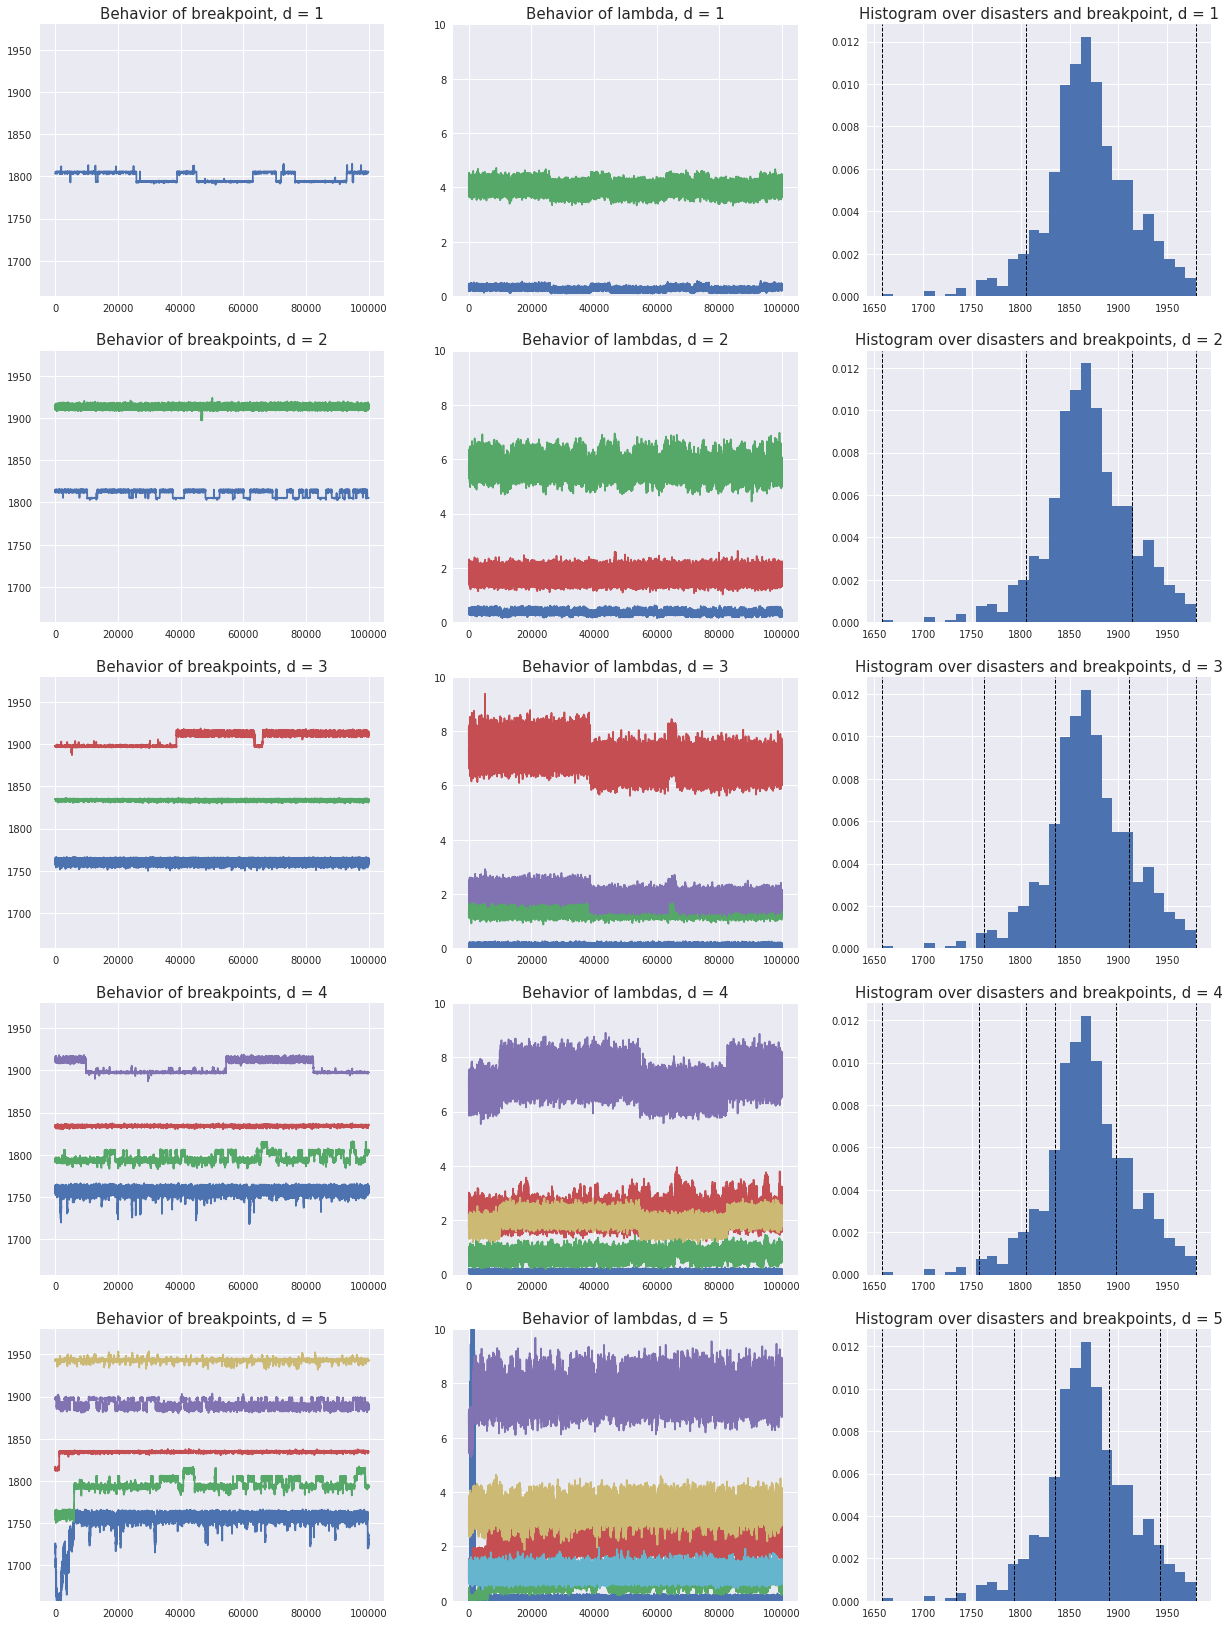

In [64]:
fig, axes = plt.subplots(5, 3, figsize = (21,29))

s = lambda n: "s" if (n > 1) else ""
axes[0, 0]._shared_x_axes.join(axes[0, 0], axes[1,0])
rates = np.zeros(5)
for n in np.arange(1,6):

    print(n)

    breakpoints, thetas, lambdas, probs, accepts = init_mcmc(N = 10**5, 
                                                            num_breakpoints = n, 
                                                            psi = 20, 
                                                            rho = 0.025,
                                                            burn_in = 10**3, 
                                                            print_debug = False)

    rates[n - 1] = np.sum(accepts)/np.size(accepts)

    axes[n - 1, 0].plot(breakpoints[:, 1:-1])
    axes[n - 1, 0].set_title(f'Behavior of breakpoint{s(n)}, d = {n}', fontsize=15)
    axes[n - 1, 0].set_ylim([1658, 1980])

    axes[n - 1, 1].plot(lambdas)
    axes[n - 1, 1].set_title(f'Behavior of lambda{s(n)}, d = {n}', fontsize=15)
    axes[n - 1, 1].set_ylim([0, 10])


    axes[n - 1, 2].hist(disasters, bins = 'auto', density  = True)
    axes[n - 1, 2].set_title(f'Histogram over disasters and breakpoint{s(n)}, d = {n}', fontsize=15)

    for breakpoint in breakpoints[-1]:
        axes[n - 1, 2].axvline(breakpoint, color='k', linestyle='dashed', linewidth=1)

plt.savefig("images/chain_behavior.png")

In [99]:


rates_dict = [{"Acceptance rates" : "", "d = 1" : rates[0], "d = 2" : rates[1], "d = 3" : rates[2], "d = 4" : rates[3], "d = 5" : rates[4]}]
df = pd.DataFrame(rates_dict)
df

Acceptance rates    d = 1     d = 2    d = 3    d = 4     d = 5
0                   0.04646  0.214755  0.24961  0.34139  0.381862

0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009000000000000001 0.010000000000000002 0.011 0.012 0.013000000000000001 0.014000000000000002 0.015 0.016 0.017 0.018000000000000002 0.019000000000000003 0.02 0.021 0.022000000000000002 0.023 0.024 0.025 0.026000000000000002 0.027000000000000003 0.028 0.029 0.030000000000000002 0.031 0.032 0.033 0.034 0.035 0.036000000000000004 0.037000000000000005 0.038 0.039 0.04 0.041 0.042 0.043000000000000003 0.044000000000000004 0.045 0.046 0.047 0.048 0.049 0.05 0.051000000000000004 0.052000000000000005 0.053000000000000005 0.054 0.055 0.056 0.057 0.058 0.059000000000000004 0.060000000000000005 0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07 0.07100000000000001 0.07200000000000001 0.07300000000000001 0.074 0.075 0.076 0.077 0.078 0.079 0.08 0.081 0.082 0.083 0.084 0.085 0.08600000000000001 0.08700000000000001 0.08800000000000001 0.089 0.09 0.091 0.092 0.093 0.094 0.095 0.096 0.097 0.098 0.099 0.1

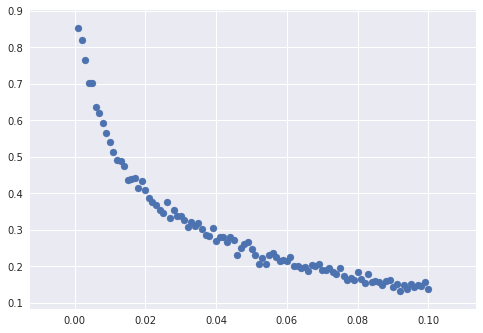

In [8]:
n = 100
rho_min = 0.001
rho_max = 0.1

psi = 20
num_breakpoints = 4

rhos = np.linspace(rho_min, rho_max, n)
acceptance = np.zeros(n)

for index in range(n):
    print(f' {rhos[index]}', end="")
    _, _, _, _, accepts = init_mcmc(N = 10**3, num_breakpoints = num_breakpoints, psi = psi, rho = rhos[index] , burn_in = 10**2, print_debug = False)
    acceptance[index] = np.sum(accepts)/np.size(accepts)
plt.scatter(rhos, acceptance)

In [65]:
n = 50
psi_min = 1
psi_max = 50

num_breakpoints = 3

psis = np.linspace(psi_min, psi_max, n)

lambdas_mean = np.zeros((n, 4))
lambdas_var = np.zeros((n, 4))

thetas_mean = np.zeros(n)
thetas_var = np.zeros(n)

for index in range(n):
    print(f' {psis[index]}', end="")
    _, theta, lambdas, _, _ = init_mcmc(N = 10**4, num_breakpoints = num_breakpoints, psi = psis[index], rho = 0.025 , burn_in = 10**2, print_debug = False)
    
    thetas_mean[index] = np.mean(theta)
    thetas_var[index] = np.var(theta)

    lambdas_mean[index] = lambdas.mean(axis=0)
    lambdas_var[index] = lambdas.var(axis=0)


1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0

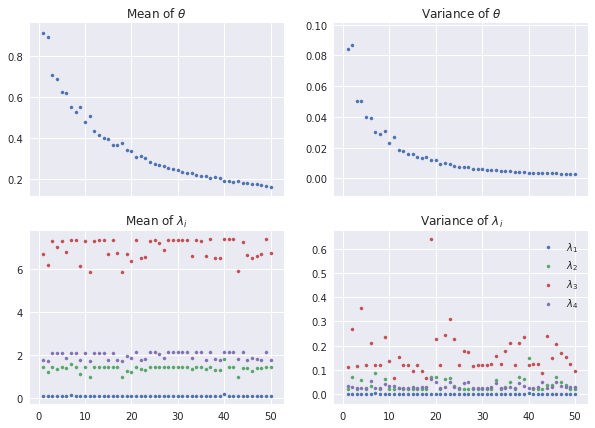

In [96]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize = (10,7))

axes[0, 0].scatter(psis, thetas_mean, s = 10)
axes[0, 1].scatter(psis, thetas_var, s = 10)

i = 1

for lamba in lambdas_mean.swapaxes(0,1):
    axes[1,0].scatter(psis, lamba, s = 10, label=f'$\lambda_{i}$ ')
    i+=1

i = 1
for lamba in lambdas_var.swapaxes(0,1):
    axes[1,1].scatter(psis, lamba, s = 10, label=f'$\lambda_{i}$ ')
    i+=1

axes[0, 0].set_title(r"Mean of $\theta$")
axes[0, 1].set_title(r"Variance of $\theta$")
axes[1, 0].set_title("Mean of $\lambda_i$")
axes[1, 1].set_title("Variance of $\lambda_i$")

axes[1, 1].legend()

saveimg("psi.png", fig)

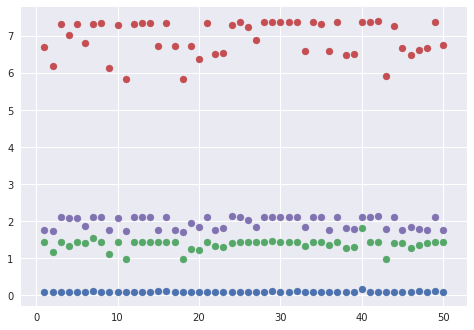

In [70]:
for lamba in lambdas_mean.swapaxes(0,1):
    plt.scatter(psis, lamba)

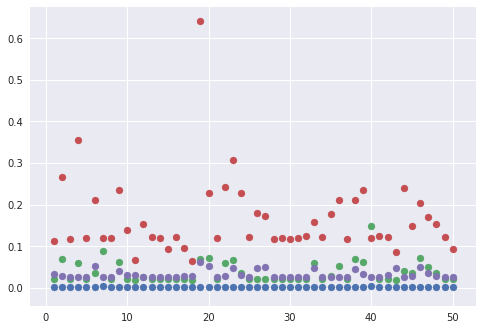

In [71]:
for lamba in lambdas_var.swapaxes(0,1):
    plt.scatter(psis, lamba)